# DOTA

- [Homepage](https://captain-whu.github.io/DOTA/index.html)
- [Source for the dataset used in this course](https://datasetninja.com/dota#download)

The DOTA dataset and it's license can be found in:

`/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/data/dota*`

- `/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/data/dota` holds the entire DOTA v2 dataset  
- `/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/data/dota-subset` holds a development subset of the DOTA v2 dataset

This notebook documents how the DOTA dataset, received from `dataset-ninja` is further prepared to align with a simple HBB (horizontal bounding box) training process.

>Note: If you are interested in an OBB (oriented bounding box) training, the original data of the labels will not be changed and is alwaysa available. 

In [1]:
from pathlib import Path

DOTA_SET = 'dota-subset' # possible values: dota-subset, dota
SPLIT = 'train' # possible values: train, val, test-dev

DATA_ROOT = Path('/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/data/')
DOTA_ROOT = DATA_ROOT / DOTA_SET

META_FILE = DOTA_ROOT / 'meta.json'
LABELS_DIR = DOTA_ROOT / SPLIT / 'ann'
IMGS_DIR = DOTA_ROOT / SPLIT / 'img'

## Assign hotkey values to classes in the meta.json file


In [2]:
import json

# Load the JSON data from the file
with open(META_FILE) as f:
    meta = json.load(f)

# Iterate over the classes and assign hotkey values
for i, cls in enumerate(meta['classes'], start=1):
    cls['hotkey'] = i

with open(META_FILE, 'w') as f:
    json.dump(meta, f, indent=4)

## Create a label map file with a background class


In [3]:
with open(META_FILE) as f:
    meta = json.load(f)

title_to_hotkey = {cls['title']: cls['hotkey'] for cls in meta['classes']}
title_to_hotkey['background'] = 0


with open(DOTA_ROOT / 'label_map.json', 'w') as f:
    json.dump(title_to_hotkey, f, indent=4)

## Generate flat annotation tables from JSON files

In [4]:
import csv

def generate_flat_annotation_file(json_file, label_map, output_file):
    with open(json_file) as f:
        data = json.load(f)

    # Extract the image file name from the JSON file name
    img_file = json_file.stem

    bboxes = []
    classes = []
    difficults = []

    # Iterate over the JSON objects and extract annotation information
    for obj in data['objects']:
        # Extract bounding box information and convert to XYXY format
        # Convert OBB to HBB format
        exterior = obj['points']['exterior']
        x_min = min(point[0] for point in exterior)
        y_min = min(point[1] for point in exterior)
        x_max = max(point[0] for point in exterior)
        y_max = max(point[1] for point in exterior)
        bbox = f"{x_min} {y_min} {x_max} {y_max}"
        bboxes.append(bbox)
        
        # Map class title to hotkey integer
        class_title = obj['classTitle']
        class_hotkey = label_map[class_title]
        classes.append(str(class_hotkey))
        
        # Extract difficult tag
        difficult_tag = next(tag for tag in obj['tags'] if tag['name'] == 'difficult')
        difficult_value = difficult_tag['value'] == 'True'
        difficults.append(str(difficult_value))

    # Create the table row
    row = [img_file, ';'.join(bboxes), ';'.join(classes), ';'.join(difficults)]

    # Write the row to a CSV file
    with open(output_file, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(row)

In [ ]:
label_map_file = DOTA_ROOT / 'label_map.json'

for i in ["train", "val", "test-dev"]:

    output_file = DOTA_ROOT / f'{i}_split.csv'

    # Load the label map
    with open(label_map_file) as f:
        label_map = json.load(f)

    # Write the header to the CSV file once
    with open(output_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['img_file', 'bbox', 'class', 'difficult'])

    # Get the list of JSON files from LABELS_DIR
    LABELS_DIR = DOTA_ROOT / i / 'ann'
    json_files = list(LABELS_DIR.glob('*.json'))

    # Process each JSON file
    for json_file in json_files:
        generate_flat_annotation_file(json_file, label_map, output_file)

## Randomly visualize image annotation pairs from flat annotation csv

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import pandas as pd

def visualize_random_annotation(split, meta_file, imgs_dir, img_file=None):

    csv_file = DOTA_ROOT / f'{split}_split.csv'

    # Load the META_FILE to get colors
    with open(meta_file) as f:
        meta = json.load(f)

    # Create a dictionary mapping 'hotkey' to 'color'
    hotkey_to_color = {cls['hotkey']: cls['color'] for cls in meta['classes']}

    # Read the annotation CSV file using pandas
    df = pd.read_csv(csv_file)

    # Select a random row
    row = df.sample(n=1).iloc[0]

    if img_file:
        row = df[df['img_file'] == img_file].iloc[0]

    
    img_file = row['img_file']
    bboxes = row['bbox'].split(';')
    classes = row['class'].split(';')

    img_file_path = Path(imgs_dir) / img_file
    fig, ax = plt.subplots(figsize=(24, 24))

    img = plt.imread(img_file_path)
    ax.imshow(img)

    for bbox, class_hotkey in zip(bboxes, classes):
        x_min, y_min, x_max, y_max = map(float, bbox.split())
        width = x_max - x_min
        height = y_max - y_min
        color = hotkey_to_color[int(class_hotkey)]
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

    plt.show()


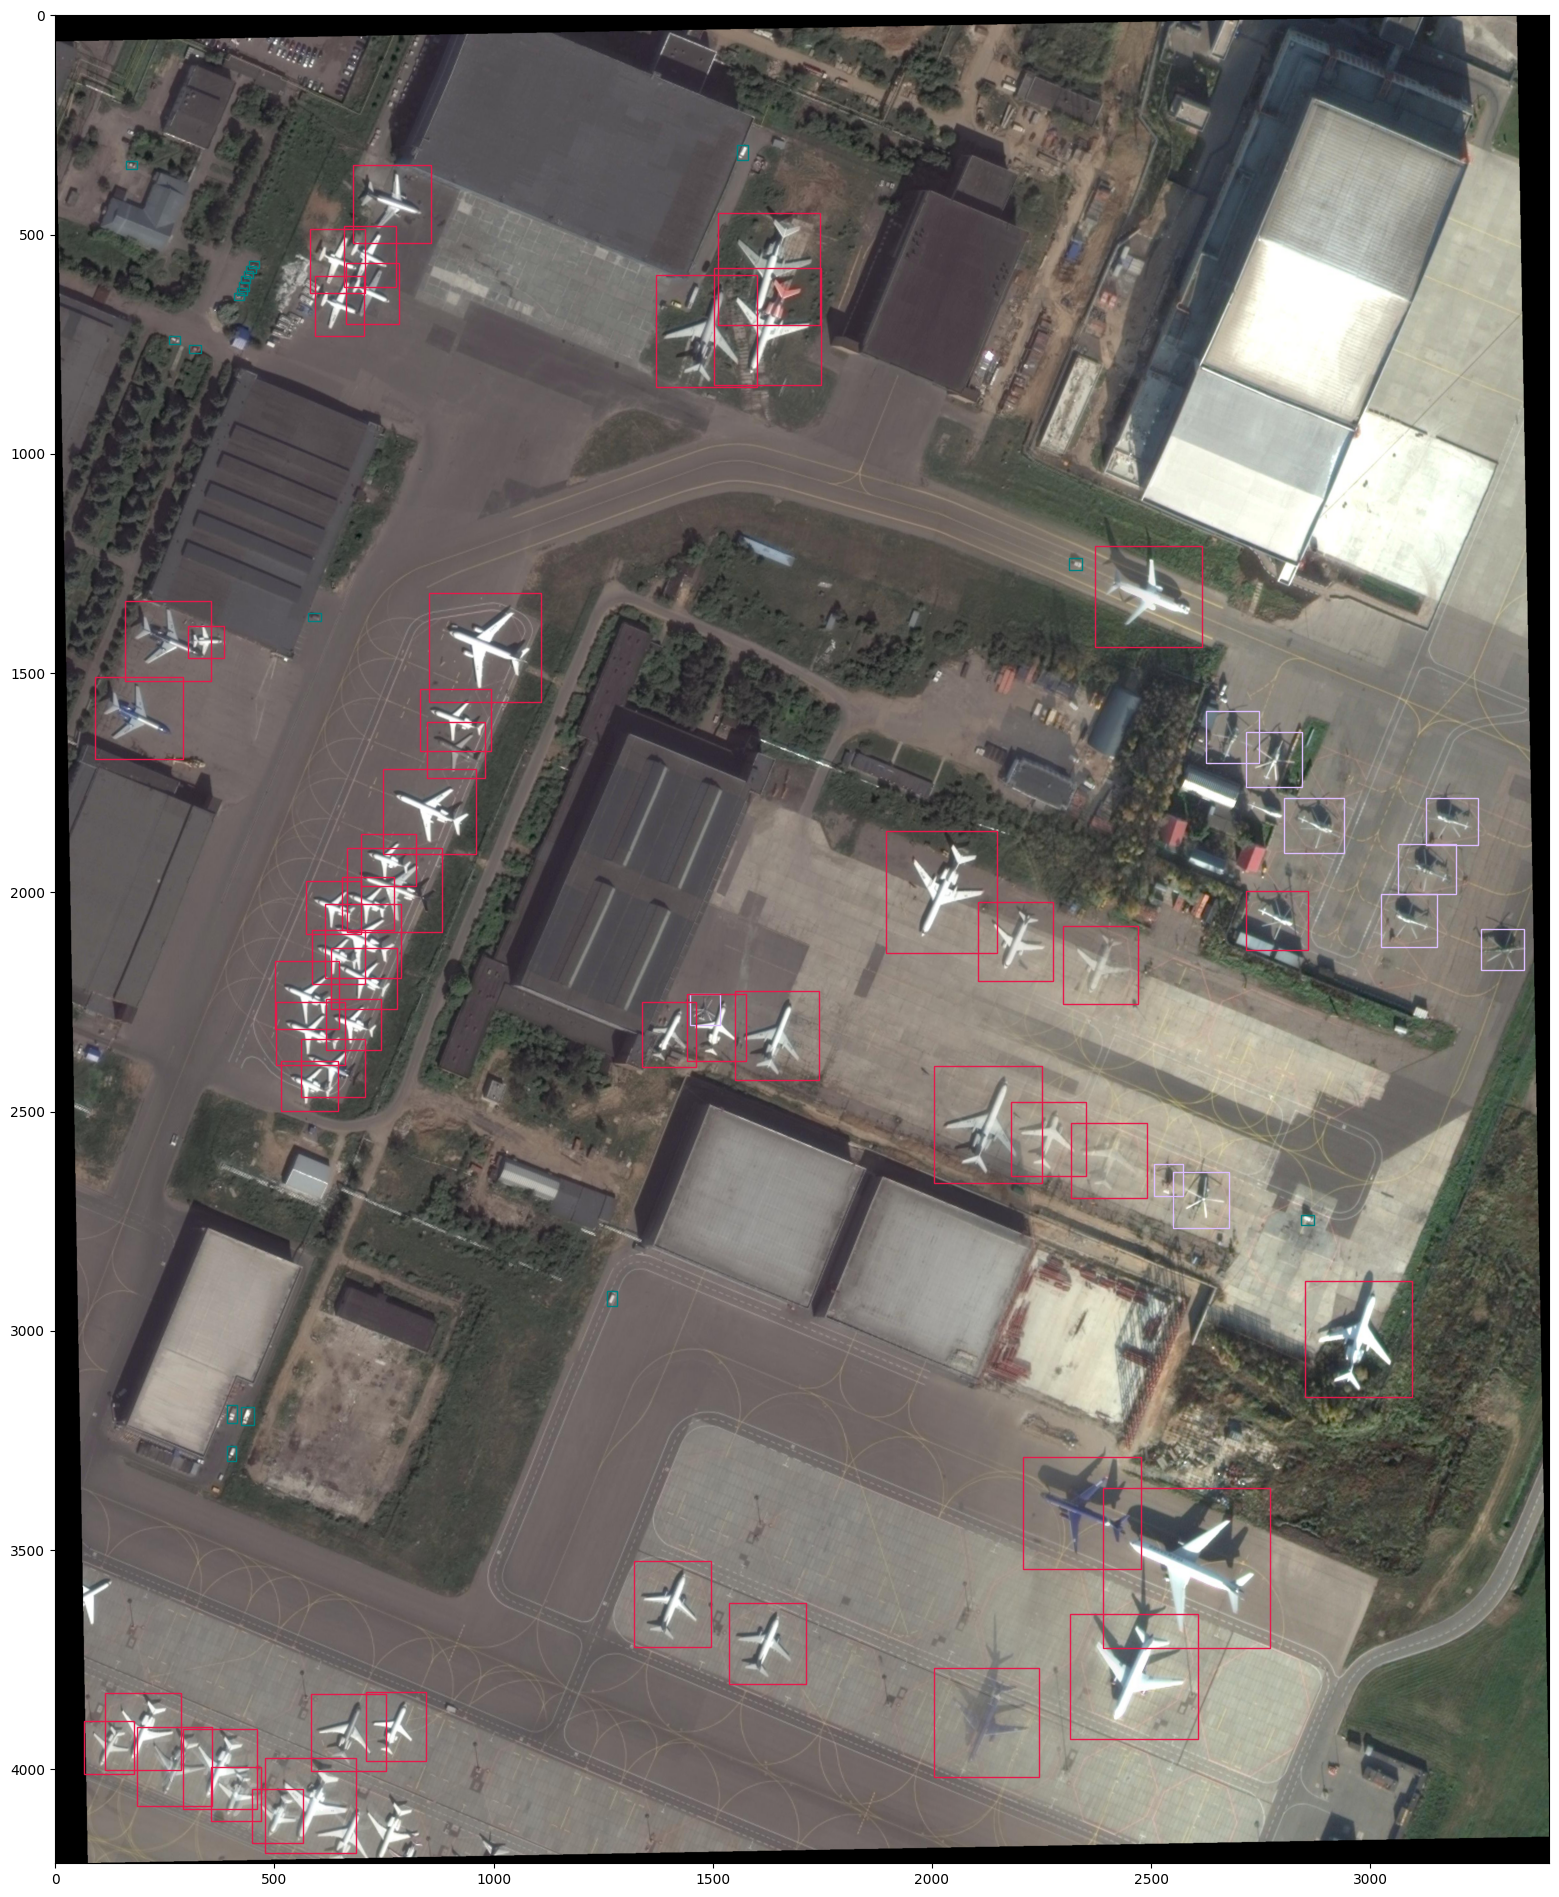

In [6]:
label_map_file = DOTA_ROOT / 'label_map.json'

visualize_random_annotation('train', META_FILE, IMGS_DIR)

In [7]:
visualize_random_annotation('train', META_FILE, IMGS_DIR, 'P1868.png')

IndexError: single positional indexer is out-of-bounds